## Data Wrangling

### Imports

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_from_disk
from collections import Counter
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import torch
import evaluate
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [3]:
# Load "amazon_polarity" dataset (https://huggingface.co/datasets/amazon_polarity)
data = load_dataset('amazon_polarity')

README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [5]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


In [7]:
train = data['train']

In [9]:
train.features

{'label': ClassLabel(names=['negative', 'positive'], id=None),
 'title': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None)}

In [11]:
train[:5]

{'label': [1, 1, 1, 1, 1],
 'title': ['Stuning even for the non-gamer',
  'The best soundtrack ever to anything.',
  'Amazing!',
  'Excellent Soundtrack',
  'Remember, Pull Your Jaw Off The Floor After Hearing it'],
 'content': ['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
  "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are g

In [13]:
# Check for missing values
cols = ['label', 'title', 'content']
for col in cols:
    print(any(value is None for value in train[col]))

False
False
False


## Exploratory Data Analysis

In [15]:
# Check for class imbalance
label_counts = Counter(train["label"])
print(label_counts)

Counter({1: 1800000, 0: 1800000})


In [17]:
# Combine title and content
def combine(data):
    data['text'] = data['title'] + ' ' + data['content']
    return data

train = train.map(combine)

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

In [19]:
train.features

{'label': ClassLabel(names=['negative', 'positive'], id=None),
 'title': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

In [21]:
train[0]

{'label': 1,
 'title': 'Stuning even for the non-gamer',
 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 'text': 'Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}

In [ ]:
test = data['test']
test = test.map(combine)

In [ ]:
# Remove redundant columns after combining
train = train.remove_columns(['title', 'content'])
test = test.remove_columns(['title', 'content'])

In [ ]:
# Save train and test sets to avoid remapping
train.save_to_disk('E:/datasets/train')
test.save_to_disk('E:/datasets/test')

In [8]:
# Load datasets
train = load_from_disk('E:/datasets/train')
test = load_from_disk('E:/datasets/test')

In [7]:
# Check for empty text entries
empty = [i for i, text in enumerate(train['text']) if not text.strip()]
print(f'Empty texts: {len(empty)}')

Empty texts: 0


In [9]:
empty = [i for i, text in enumerate(test['text']) if not text.strip()]
print(f'Empty texts: {len(empty)}')

Empty texts: 0


In [11]:
# Most common words
stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in re.findall(r'\b\w+\b', text.lower()) if word not in stop_words]

sample = train.select(range(5000))['text']
all_words = [word for text in sample for word in tokenize(text)]
common_words = Counter(all_words).most_common(20)

print(common_words)

[('book', 2952), ('one', 2046), ('like', 1378), ('great', 1353), ('good', 1348), ('read', 1224), ('would', 1201), ('time', 1004), ('get', 974), ('movie', 969), ('really', 783), ('first', 766), ('much', 709), ('buy', 708), ('well', 705), ('even', 693), ('product', 663), ('love', 621), ('best', 550), ('better', 543)]


In [13]:
# Check that labels match text
for i in range(20):
    print(f'Label: {train[i]['label']}, Text: {train[i]['text'][:200]}')

Label: 1, Text: Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cros
Label: 1, Text: The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunor
Label: 1, Text: Amazing! This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you've played the game) and the hope in "A Distant Promis
Label: 1, Text: Excellent Soundtrack I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favor
Label: 1, Text: Remember, Pull Your Jaw Off The Floor After Hearing it If you've played the game, you know how divine the music is! 

In [15]:
# Check for duplicate reviews
dup_count = sum(count > 1 for count in Counter(train['text']).values())
print(f'Duplicate entries: {dup_count}')

Duplicate entries: 0


In [17]:
# For completion, check duplicates in test set as well
dup_count = sum(count > 1 for count in Counter(test['text']).values())
print(f'Duplicate entries: {dup_count}')

Duplicate entries: 0


In [16]:
df = train.to_pandas()

<Axes: >

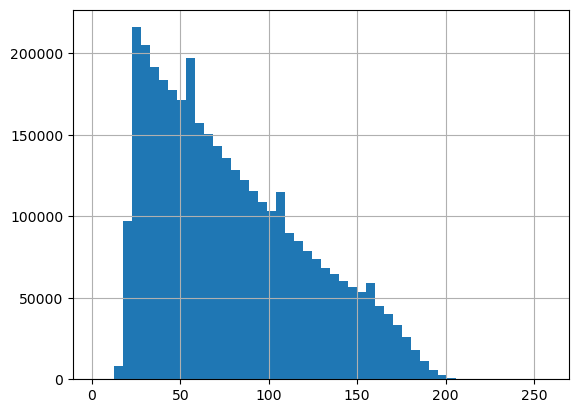

In [21]:
# Check text length distribution in words
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].hist(bins=50)

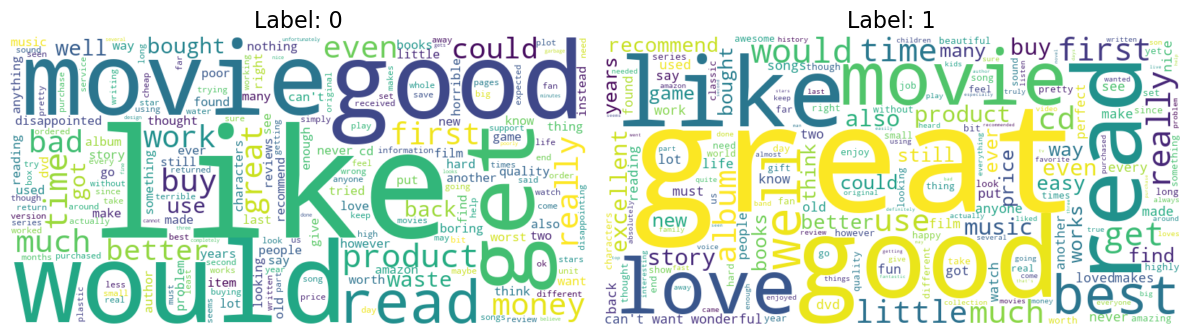

In [25]:
# Initialize the TweetTokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False)

# Custom tokenizer using TweetTokenizer
def custom_tokenizer(text):
    tokens = tweet_tokenizer.tokenize(text)
    # Keep only alphabetic tokens or contractions (e.g., "don't")
    tokens = [t for t in tokens if re.match(r"[a-z]+('[a-z]+)?$", t)]
    return tokens

# Base stopwords plus custom extras (keep contraction suffixes like "n't" etc.)
base_stopwords = set(stopwords.words('english'))
extra_stopwords = {'one', 'book'}
custom_stopwords = list(base_stopwords.union(extra_stopwords))

# Sample the DataFrame to balance labels
sampled_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 2000), random_state=42)
)

# Get unique labels
labels = sampled_df['label'].unique()
num_labels = len(labels)

# Set up subplots
fig, axes = plt.subplots(1, num_labels, figsize=(6 * num_labels, 6))
if num_labels == 1:
    axes = [axes]

# Generate TF-IDF word cloud for each class
for i, label in enumerate(labels):
    class_texts = sampled_df[sampled_df['label'] == label]['text'].dropna().astype(str)

    tfidf = TfidfVectorizer(
        tokenizer=custom_tokenizer,
        stop_words=custom_stopwords,
        token_pattern=None,  # Required when using a custom tokenizer
        max_features=1000
    )
    tfidf_matrix = tfidf.fit_transform(class_texts)

    # Get average TF-IDF scores
    scores = tfidf_matrix.mean(axis=0).A1
    words = tfidf.get_feature_names_out()
    tfidf_scores = dict(zip(words, scores))

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Label: {label}', fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The word cloud gives a quick look at collections of the most commonly used words for both negative (label: 0) and positive (label: 1) reviews.

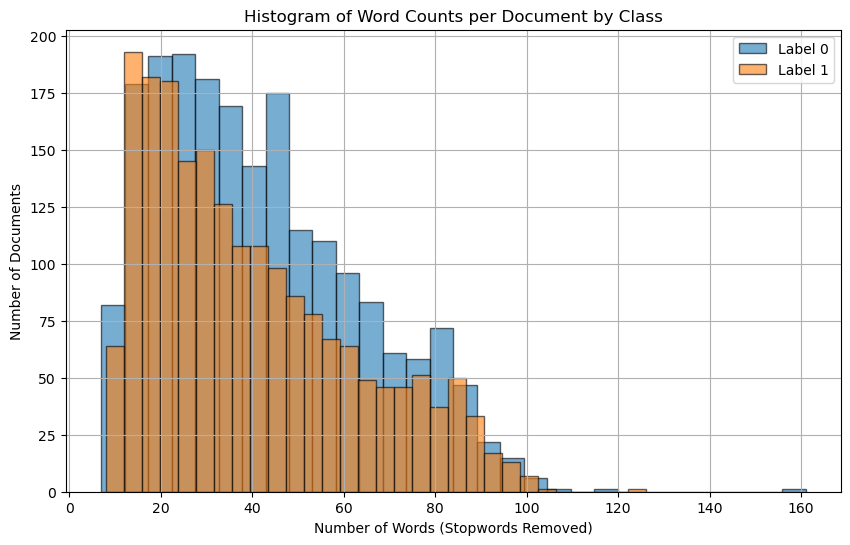

In [27]:
# Compute unique word counts by class
sampled_df['word_count'] = sampled_df['text'].apply(lambda x: len(tokenize(str(x))))

# Plot histograms by class
labels = sampled_df['label'].unique()
plt.figure(figsize=(10, 6))

for label in labels:
    subset = sampled_df[sampled_df['label'] == label]
    plt.hist(subset['word_count'], bins=30, alpha=0.6, label=f'Label {label}', edgecolor='black')

plt.title('Histogram of Word Counts per Document by Class')
plt.xlabel('Number of Words (Stopwords Removed)')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True)
plt.show()

The histogram of word counts by class shows that, on average, negative reviews tend to be longer.

In [24]:
# Bigram frequency
vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    ngram_range=(2, 2),  # Bigrams
    stop_words='english',
    token_pattern=None  # Important: disables default pattern so custom tokenizer is used
)
X = vectorizer.fit_transform(sampled_df['text'])
sum_words = X.sum(axis=0)
bigrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)

In [26]:
for bigram, freq in bigrams_freq[:20]:
    print(f'{bigram}: {freq}')

read book: 121
waste money: 92
highly recommend: 63
year old: 61
years ago: 61
don't know: 61
don't waste: 60
waste time: 58
book read: 55
great book: 54
don't buy: 48
save money: 47
recommend book: 45
long time: 45
great product: 44
reading book: 43
customer service: 42
i've read: 41
good book: 41
i'm sure: 41


In [38]:
# Trigram frequency
vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    ngram_range=(3, 3),
    stop_words='english',
    token_pattern=None
)
X = vectorizer.fit_transform(sampled_df['text'])
sum_words = X.sum(axis=0)
trigrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
trigrams_freq = sorted(trigrams_freq, key=lambda x: x[1], reverse=True)

In [40]:
for trigram, freq in trigrams_freq[:20]:
    print(f'{trigram}: {freq}')

don't waste money: 37
waste time money: 22
don't waste time: 18
highly recommend book: 11
blah blah blah: 10
book i've read: 9
year old son: 9
jake roberts vs: 8
books i've read: 7
does good job: 7
seen long time: 6
complete waste time: 5
book years ago: 5
don't buy book: 5
waste money bought: 5
does great job: 5
save time money: 5
called customer service: 5
just finished reading: 5
movies i've seen: 5


Bigrams and trigrams can be used as input, rather than single words, to improve model performance.

In [37]:
# Check corpus-wide vocabulary size
all_tokens = [token for text in sample for token in tokenize(text)]
vocab = set(all_tokens)
print("Vocabulary size:", len(vocab))

Vocabulary size: 21156


In [39]:
# Check for text overlap between training and test sets
train_df = train.to_pandas()
test_df = test.to_pandas()

train_texts = set(train_df['text'].str.strip().str.lower())
test_texts = set(test_df['text'].str.strip().str.lower())

# Intersection
overlap_texts = train_texts.intersection(test_texts)

print(f"Exact overlapping texts: {len(overlap_texts)}")

Exact overlapping texts: 82


While exact overlap can be problematic between the training and test sets, 82 is a small fraction given the size of each set.

In [41]:
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Percent of test overlapped: {100 * len(overlap_texts) / len(test_df):.2f}%")

Train size: 3600000
Test size: 400000
Percent of test overlapped: 0.02%


## Preprocessing

In [9]:
def preprocess(data, rm_stop_words=True):
    text = data['text'].lower()
    text = re.sub(r"[^\w\s']", '', text)
    if rm_stop_words:
        tokens = text.split()
        tokens = [t for t in tokens if t not in stop_words]
        return {'text': ' '.join(tokens)}
    else:
        return {'text': text}

In [ ]:
train_tfidf = train.map(preprocess)
test_tfidf = test.map(preprocess)

In [ ]:
train_tfidf.save_to_disk('E:/datasets/train_tfidf')
test_tfidf.save_to_disk('E:/datasets/test_tfidf')

In [11]:
train_transformer = train.map(lambda x: preprocess(x, rm_stop_words=False))
test_transformer = test.map(lambda x: preprocess(x, rm_stop_words=False))

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

In [ ]:
train_transformer.save_to_disk('E:/datasets/train_transformer')
test_transformer.save_to_disk('E:/datasets/test_transformer')

## Modeling

### Logistic Regression

In [47]:
# Load locally saved datasets
train_tfidf = load_from_disk('E:/datasets/train_tfidf')
test_tfidf = load_from_disk('E:/datasets/test_tfidf')

In [49]:
# Extract columns for X and y
X_train = train_tfidf['text']
y_train = train_tfidf['label']
X_test = test_tfidf['text']
y_test = test_tfidf['label']

In [50]:
# Create pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(solver='liblinear'))
])

In [51]:
# Train model and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[180207  19793]
 [ 18539 181461]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90    200000
           1       0.90      0.91      0.90    200000

    accuracy                           0.90    400000
   macro avg       0.90      0.90      0.90    400000
weighted avg       0.90      0.90      0.90    400000



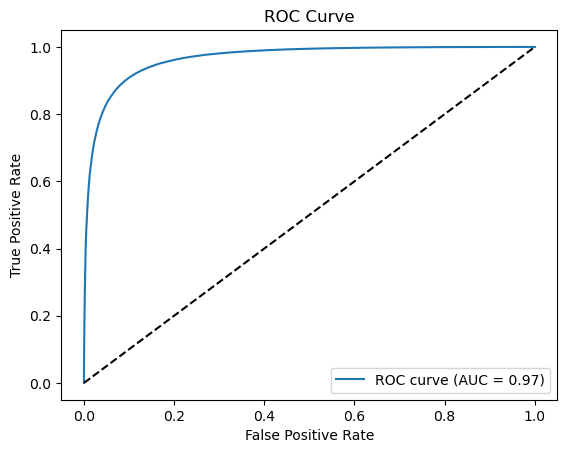

In [55]:
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

The logistic regression model was implemented as a baseline for sentiment classification. It followed a standard NLP preprocessing pipeline:
* Lowercasing and punctuation removal
* Stopword removal
* Feature extraction using TF-IDF with up to 10,000 unigrams and bigram features
* Classification using Logistic Regression with the liblinear solver

| Metric    | Class 0 (Neg) | Class 1 (Pos) | Overall |
| --------- | ------------- | ------------- | ------- |
| Precision | 0.91          | 0.90          | 0.90    |
| Recall    | 0.90          | 0.91          | 0.90    |
| F1-Score  | 0.90          | 0.90          | 0.90    |
| Accuracy  | -             | -             | 90.4%   |
| ROC-AUC   | -             | -             | 0.97    |

The ROC curve shows strong separation between classes, with an AUC of 0.97, indicating high discriminative ability. Precision, recall, F1-score, and accuracy all fall right around 90%, which is a very good baseline.

### DistilBERT base (uncased)

In [61]:
# Load locally stored datasets
train_tranformer = load_from_disk('train_transformer')
test_transformer = load_from_disk('test_transformer')

Loading dataset from disk:   0%|          | 0/22 [00:01<?, ?it/s]

In [13]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [15]:
# Tokenize text function
def tokenize_function(data):
    return tokenizer(data['text'], truncation=True, padding='max_length')

In [17]:
# Tokenize text using distilBERT tokenizer
train_tokenized = train_transformer.map(tokenize_function, batched=True)
test_tokenized = test_transformer.map(tokenize_function, batched=True)

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

In [19]:
# Save datasets for later use
train_tokenized.save_to_disk('E:/datasets/train_dbert')
test_tokenized.save_to_disk('E:/datasets/test_dbert')

Saving the dataset (0/22 shards):   0%|          | 0/3600000 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/400000 [00:00<?, ? examples/s]

In [8]:
# Load datasets
train_dbert = load_from_disk('E:/datasets/train_dbert')
test_dbert = load_from_disk('E:/datasets/test_dbert')

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from transformers.trainer_utils import get_last_checkpoint
import numpy as np
import evaluate
from datasets import load_from_disk

# Load dataset from local storage
train_dbert = load_from_disk("E:/datasets/train_dbert")
test_dbert = load_from_disk('E:/datasets/test_dbert')

# Subsample to ~344,000 examples to target ~43,000 iterations in 2 epochs
train_dbert = train_dbert.shuffle(seed=42).select(range(344_000))
train_dbert.set_format(type="torch")  # Efficient memory usage

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy.compute(predictions=preds, references=labels)['accuracy'],
        'f1': f1.compute(predictions=preds, references=labels, average='weighted')['f1'],
    }

# Training arguments: no intermediate eval, save checkpoints
training_args = TrainingArguments(
    output_dir='E:/datasets/results',
    eval_strategy="no",              # No intermediate evaluation
    save_strategy="steps",                 # Save model periodically
    save_steps=5000,
    save_total_limit=1,                    # Keep only the latest checkpoint
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='E:/datasets/logs',
    logging_steps=100,
    report_to='none',
    load_best_model_at_end=False,          # No best model tracked without eval
    dataloader_num_workers=4,
    fp16=True,
    gradient_accumulation_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dbert,
    eval_dataset=test_dbert,       
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
last_checkpoint = get_last_checkpoint(training_args.output_dir)

if last_checkpoint is not None:
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    trainer.train()

# Final evaluation
metrics = trainer.evaluate()
print(metrics)

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\justi\AppData\Local\Temp\ipykernel_17096\2322123922.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.456800
200,0.288700
300,0.255900
400,0.233200
500,0.228300
600,0.242700
700,0.234800
800,0.196500
900,0.221100
1000,0.197000


{'eval_loss': 0.14977984130382538, 'eval_accuracy': 0.9596925, 'eval_f1': 0.9596924780764868, 'eval_runtime': 4919.8766, 'eval_samples_per_second': 81.303, 'eval_steps_per_second': 2.541, 'epoch': 2.0}


In [16]:
train_dbert = train_dbert.shuffle(seed=42).select(range(344_000))
train_dbert.set_format(type="torch")  # Efficient memory usage

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('E:/datasets/results/checkpoint-43000') # Use saved best model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

# Training arguments: no intermediate eval, save checkpoints
training_args = TrainingArguments(
    output_dir='E:/datasets/results',
    eval_strategy="no",              # No intermediate evaluation
    save_strategy="steps",                 # Save model periodically
    save_steps=5000,
    save_total_limit=1,                    # Keep only the latest checkpoint
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='E:/datasets/logs',
    logging_steps=100,
    report_to='none',
    load_best_model_at_end=False,          # No best model tracked without eval
    dataloader_num_workers=4,
    fp16=True,
    gradient_accumulation_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dbert,
    eval_dataset=test_dbert,       
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [18]:
predictions = trainer.predict(test_dbert)

In [20]:
# Extract values
y_true = predictions.label_ids
y_logits = predictions.predictions
y_pred = np.argmax(y_logits, axis=-1)
y_prob = torch.nn.functional.softmax(torch.tensor(y_logits), dim=-1)[:, 1].numpy()

# Print report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    200000
           1       0.96      0.96      0.96    200000

    accuracy                           0.96    400000
   macro avg       0.96      0.96      0.96    400000
weighted avg       0.96      0.96      0.96    400000



Note: Due to limited hardware resources, the DistilBERT model was trained on a 344K subset (~10%) of the original 3.6M training samples. The evaluation was still performed on the full 400K test set. The logistic regression baseline was trained on the full training set.

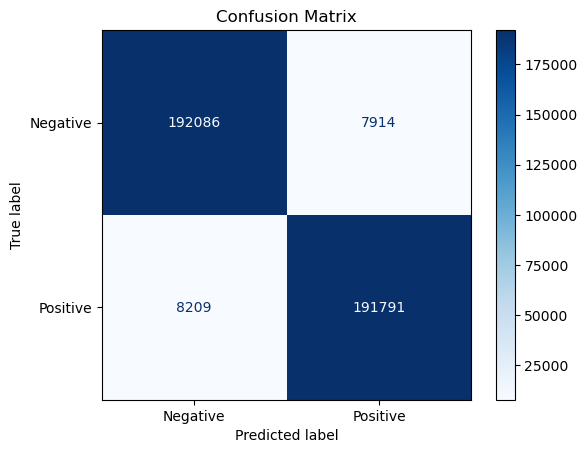

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

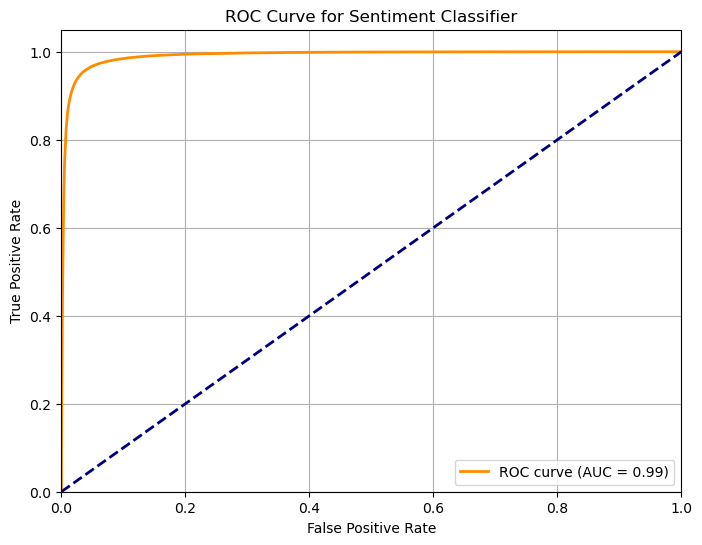

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sentiment Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The DistilBERT-based model achieved an accuracy of **95.97%**, F1 score of **0.96**, and ROC-AUC of **0.99**. These metrics indicate that the model is highly effective at distinguishing between positive and negative sentiments.

While the ROC-AUC shows the model is excellent at ranking samples, the F1 score reflects strong precision and recall at the default classification threshold. The confusion matrix confirms that both false positives and false negatives are low.

**Strengths:**
- Robust language understanding from pre-trained DistilBERT.
- High generalization (low evaluation loss).

**Weaknesses / Risks:**
- May struggle with sarcasm, slang, or domain-specific phrases.
- Not yet tested on out-of-distribution data (e.g., other review domains or social media text).

**Recommendations:**
- Use this model to automate review tagging or flagging at scale.
- Consider fine-tuning further if deploying on a different domain or adding classes.
- Add explainability tools like SHAP/LIME if used in high-stakes decision-making.


## Summary & Recommendations

### Project Overview
This project aimed to build a high-performance sentiment classifier using a large, balanced dataset of 3.6 million labeled text samples (positive and negative). Two models were implemented:

* Baseline Logistic Regression

* Transformer-based DistilBERT

| Metric           | Logistic Regression | DistilBERT             |
| ---------------- | ------------------- | ---------------------- |
| Accuracy         | 90.4%               | 95.97%                 |
| F1 Score         | 0.90                | 0.96                   |
| ROC-AUC          | 0.97                | 0.99                   |
| Inference Time   | Fast                | Slower                 |
| Interpretability | High                | Moderate               |
| Preprocessing    | Heavy (TF-IDF)      | Minimal (tokenization) |

### Insights
Logistic regression performed surprisingly well with traditional preprocessing and TF-IDF features, reaching a 90% F1 score and 0.97 ROC-AUC.
DistilBERT significantly outperformed it in terms of raw classification accuracy and F1, due to its contextual understanding of language.
However, logistic regression remains attractive for fast inference, deployment in resource-constrained environments, or when interpretability is a key requirement.

### Recommendation
Use DistilBERT as the production model for sentiment classification due to its superior accuracy and F1 performance. However, retain the logistic regression model as a lightweight alternative for fallback scenarios or interpretability-driven applications.

### Future Work
The project demonstrates how transformer-based language models can outperform traditional methods with minimal feature engineering. Future work could include expanding to a multi-class (1-5 stars) sentiment, incorporating review metadata (helpfulness reviews or product category), experimenting with larger transformers (RoBERTa or DeBERTa), or deploying the model via a real-time API like FastAPI or Flask.